There will be description stuff here when I know more what we are doing...

In [67]:
# fake figures dir
fake_figs_dir = '/Users/jnaiman/Downloads/tmp/fake_figs/'

# which to check?
dirs_latex = ['arxiv/9901', 'arxiv_new/2301', 'arxiv_new/2302']
base_dir_arxiv = '/Users/jnaiman/Dropbox/wwt_image_extraction/'

# savefiles
fullproc_r = '/Users/jnaiman/LMM_Figure_Parsing/resources/'

# get title and x/y labels from most frequent words
data_dir = '/Users/jnaiman/LMM_Figure_Parsing/resources/data/'

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
import pickle
import pandas as pd
import string
from glob import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import ImageColor

import spacy

# this is hacktacular from: https://github.com/ReadingTimeMachine/TexSoup
# and needs to be updated
tex_lib = '/Users/jnaiman/TexSoup/'
from sys import path
path.append(tex_lib)
import TexSoup
from TexSoup import preprocessing, postprocess

from nltk.corpus import stopwords
import time

from matplotlib import font_manager
plt.rcParams['text.usetex'] = True

nlp = spacy.load("en_core_web_sm")

# written libs
from importlib import reload # debug
import synthetic_fig_utils # debug
reload(synthetic_fig_utils) # debug
from synthetic_fig_utils import subset_by_percent, get_line_styles, \
 get_nrows_and_ncols, normalize_params_prob, get_ticks

use_uniques = True # use unique inlines
verbose = True

In [69]:
# get fonts -- see "cnn_create_synthetic_ticks" in FullProcess
dfont = pd.read_csv(fullproc_r + 'fonts.csv')
#fonts_loc = dfont['font location'].values
font_names = dfont['font name'].values
#font_names

## Functions for image generation

In [70]:
linestyles = get_line_styles()

plot_styles = plt.style.available

from matplotlib.lines import Line2D
marker_dir = Line2D.markers

markers = []
for m,mn in marker_dir.items():
    if type(m) == str:
        if 'None' not in m.lower() and 'nothing' not in mn.lower():
            #print(m, mn)
            markers.append(m)
    else:
        #print(m,mn)
        markers.append(m)

markers = np.array(markers,dtype=object)

In [71]:
# all clean words
with open(data_dir+'words_cleaned.pickle','rb') as f:
    words_cleaned = pickle.load(f)

# also cleaned words
normalized=True
pdf_letters = []; ocr_letters = []; counts = []; counts_unnormed = []
for pl,ols in words_cleaned.items():
    if normalized:
        cdiv=0.0
        for ol,c in ols.items(): # % in OCR
            cdiv += c
    else:
        cdiv = 1.0
        
    for ol,c in ols.items():
        pdf_letters.append(pl)
        ocr_letters.append(ol)
        counts.append(c/cdiv*100)
        counts_unnormed.append(c)
        
df_words_clean = pd.DataFrame({'pdf_letters':pdf_letters,
                        'ocr_letters':ocr_letters,
                        'counts':counts, 'counts unnormalized':counts_unnormed})
# stop words
# lets look for stopwords
stop_words_all = stopwords.words('English')

# get upper case alpha characters
alphas = list(string.ascii_lowercase)
alphas_lower = alphas.copy()
# add larger ones
for a in alphas_lower:
    alphas.append(a.upper())

digits = np.arange(0,10,1).astype('int').astype('str').tolist()

punctuation = list(string.punctuation)
# pop out our markers
for p in ['^','@']:
    try:
        i = punctuation.index(p)
        punctuation.pop(i)
    except:
        pass
        
not_freq_words = []
not_freq_words.extend(stop_words_all)
not_freq_words.extend(digits)
not_freq_words.extend(alphas)
not_freq_words.extend(punctuation)

# other randoms to take out
words_randoms = []
words_randoms.extend(['-','fig','et'])

df_freq = df_words_clean.loc[~((df_words_clean['pdf_letters'].isin(not_freq_words)) & (df_words_clean['ocr_letters'].isin(not_freq_words)))]
df_freq_large = df_words_clean.loc[~(df_words_clean['pdf_letters'].isin(not_freq_words))]

# how many top words?
ntop = 1000
pdf_words = df_freq_large.sort_values('counts unnormalized',ascending=False).iloc[:ntop]['pdf_letters'].values

df_freq_top = df_words_clean.loc[(df_words_clean['pdf_letters'].isin(pdf_words))&(df_words_clean['ocr_letters'].isin(pdf_words))]
df_freq_top_large = df_words_clean.loc[df_words_clean['pdf_letters'].isin(pdf_words)]
df_freq_top_large = df_freq_top_large.loc[~df_freq_top_large['pdf_letters'].isin(words_randoms)]
print(len(df_freq_top),len(df_freq_top_large))

# cut off lower-counted things
tol_count = 5
df_freq_top = subset_by_percent(df_freq_top.copy(), tol_count = tol_count) # formatting
df_freq_top_large = subset_by_percent(df_freq_top_large.copy(), tol_count = tol_count) # formatting

words = " ".join(df_freq_top_large['pdf_letters'].unique().tolist())
doc = nlp(words)

popular_nouns = []
# loop and get just the nouns
for token in doc:
    if (str(token.pos_) == 'NOUN') and (token.text not in words_randoms):
        popular_nouns.append(token.text)

5505 173468
shape of output= (1112, 5)
shape of output= (17464, 5)


In [72]:
# get a random inline math formula
recreate_inlines = False # if true, you need access to data!

if recreate_inlines:
    inlines = []
    
    texfiles = glob(base_dir_arxiv + dirs_latex[0] + '/*/*.tex')
    for i in range(1,len(dirs_latex)):
        texfiles.extend(glob(base_dir_arxiv + dirs_latex[i] + '/*/*.tex'))
    #len(texfiles)

    for ii,f in enumerate(texfiles):
        if ii%100 == 0:
            print('on', ii+1, 'of', len(texfiles), 'so far have', len(inlines), 'inline formulas')
            
    # inline_math = ''
    # while inline_math == '':
        
        #f = np.random.choice(texfiles)
        try:
            with open(f, 'r') as ff:
                tex = ff.read()
        except Exception as e:
            if verbose:
                print('issue opening file:', f)
                print(e)
            continue
    
        try:
            soup = TexSoup.TexSoup(r''+tex, tolerance=0)
        except Exception as e:
            if verbose:
                print('issue makign soup for:', f)
                print(e)
            continue
            
        # pre-process with our TexSoup
        err = False
        tex_doc = preprocessing.process_begin_end(tex) # cleaning begin/end
        tex_doc, error_accents = preprocessing.clean_accents(tex_doc) # parse accents
        if error_accents:
            continue
        # get new commands/envs
        newcommands, newenvironments = preprocessing.get_newcommands_and_newenvs(tex_doc,
                                                                             verbose=False)
        args_newcommands,err = preprocessing.find_args_newcommands(newcommands,error_out=False, 
                                                               verbose=False)
        if err:
            continue 
        args_newenvironments, err = preprocessing.find_args_newenvironments(newenvironments,
                                                                   error_out=False, verbose=False)        
        if err:
            continue
    
          
        error = False
        try:
            comments, find_replace, error = preprocessing.generate_find_replace_newcommands(args_newcommands, 
                                                                   verbose=False,arg_type = 'newcommand')  
            error = error[0]
        except:
            error = True
            
        if error:
            continue
        
        warnings = []
        try:
            tex_doc_nc, error, warnings = preprocessing.replace_newcommands_and_newenvironments(tex_doc, 
                                                                                  args_newcommands,
                                                                                  args_newenvironments,
                                                                                                verbose=True)
        except:
            error = [True]
            
        if error[0]:
            continue
            
        # try to make soup
        error = False
        try:
            soup = TexSoup.TexSoup(r''+tex_doc_nc, tolerance=0)
        except:
            error = True
        if error:
            continue
    
        # clean up commands with slashes
        error = False
        try:
            soup_clean = postprocess.clean_slash_commands(soup)
        except:
            error = True
        if error:
            continue
            
        error = False
        try:
            texout_arr = postprocess.parse_soup_to_tags(soup,tex_doc_nc, verbose=False)
        except:
            error = True
        if error:
            continue

        for t,tt in texout_arr:
            if tt == 'inline':
                inlines.append(t)
        #inlines = np.unique(inlines).tolist()

    #inlines = np.unique(inlines).tolist()
    with open(fullproc_r + 'inlines.csv','w') as f:
        for l in inlines:
            print(l.replace('\n', ' '),file=f)
    # and uniques
    inlines_u = np.unique(inlines)
    with open(fullproc_r + 'inlines_unique.csv','w') as f:
        for l in inlines_u:
            print(l.replace('\n', ' '),file=f)

    inlines_ignore = []
    for il,l in enumerate(inlines):
        try:
            plt.close('all')
            plt.plot([1,2],[1,2])
            plt.xlabel(r""+l)
            plt.savefig(fake_figs_dir + 'p1.png')
        except Exception as e:
            #print(e)
            inlines_ignore.append(il)

    with open(fullproc_r + 'inlines_uniques_ignore.csv','w') as f:
        for l in inlines_ignore:
            print(l,file=f)
else:
    if not use_uniques:
        print('not using unique inlines, not sure if this is a good idea!')
        with open(fullproc_r + 'inlines.csv', 'r') as f:
            inlines = f.readlines()
    else:
        with open(fullproc_r + 'inlines_unique.csv', 'r') as f:
            inlines = f.readlines()
        with open(fullproc_r + 'inlines_uniques_ignore.csv', 'r') as f:
            inds_ignore = f.readlines()
        inds_ignore = np.array(inds_ignore).astype('int')
        inlines = np.delete(inlines, inds_ignore)
        

print('number of inlines = ', len(inlines))

number of inlines =  33201


In [73]:
# inlines = np.unique(inlines).tolist()
# with open(fullproc_r + 'inlines.csv','w') as f:ZZZZ
#     for l in inlines:
#         print(l.replace('\n', ' '),file=f)

In [111]:
w = np.array(['hi there', 'yes', 'ok'])
p = np.random.uniform(0,1, size=len(w))

eqs = p <= 0.5

eqs, len(w[eqs])

(array([ True, False,  True]), 2)

In [76]:
# # try to make the latex stuff go faster
# csfont = {'fontname':np.random.choice(font_names)}
# words = popular_nouns
# cap = ylabel_params['capitalize']
# eq = ylabel_params['equation']
# nwords = np.random.randint(low=ylabel_params['n words']['min'],high=ylabel_params['n words']['max']+1)


# #def get_ylabels(words, cap, eq, csfonts, nwords=1):

# i = np.random.randint(0,len(words),size=nwords)
# w = np.array(words)[i]
# probs, choices = [],[]
# for k,v in cap.items():
#     choices.append(k)
#     probs.append(v)
# c = np.random.choice(choices, p=probs)
# if c == 'first':
#     for i in range(len(w)):
#         w[i] = w[i].capitalize()
# elif c == 'all':
#     for i in range(len(w)):
#         w[i] = w[i].upper()
# # turn any into random equation?
# p = np.random.uniform(0,1, size=len(w))
# eqs = p <= eq['prob']
# # if len(w[eqs]) > 0: # have some words
# #     i = np.random.randint(0,len(inlines),size=len(w[eqs]))
# #     w[eqs] = np.array(inlines)[i]
# # get all the latex words and test with this font

# if len(w[eqs]) > 0:
#     lwords = []
#     we = np.array(inlines)[np.random.randint(0,len(inlines))]
#     print(we)

# if len(w) > 1:
#     wout = r" ".join(w)
# else:
#     wout = w[0]
# wout = wout.replace('\n', '')

# # ylabel_words = get_ylabels(popular_nouns, ylabel_params['capitalize'],
# #                              ylabel_params['equation'],
# #                              nwords=np.random.randint(low=ylabel_params['n words']['min'],
# #                                                       high=ylabel_params['n words']['max']+1))
# # ylabel = ax.set_ylabel(ylabel_words, fontsize=ylabel_fontsize, **csfont)

# wout

In [77]:
w

array(['REPRODUCE', 'MAP'], dtype='<U14')

In [78]:
# LINES & SCATTERS
def get_line_data(plot_params, npoints,nlines,xmin=0, xmax=1, ymin=0, ymax=1, 
                  prob_same_x=0.1,
                  xordered=True, verbose=True,
                 pick_xrange=True, pick_yrange=True):
    """
    ymin/ymax : can be a number of a list, if list, needs to be matched up with number of nlines
    xordered : do we want to put the x-points in a monotonic order?
    """
    if (type(ymin) not in [list, np.ndarray]) and (type(ymax) not in [list, np.ndarray]):
        pass
    elif ((type(ymin) not in [list, np.ndarray]) and (type(ymax) in [list, np.ndarray])):
        if verbose: print('type of ymin and ymax must be the same!  Will fall back on ints')
        ymax = ymax[0]
    elif ((type(ymin) in [list, np.ndarray]) and (type(ymax) not in [list, np.ndarray])):
        if verbose: print('type of ymin and ymax must be the same!  Will fall back on ints')
        ymin = ymin[0]
    elif len(ymin) != nlines or len(ymax) != nlines:
        if verbose: print('length of ymax, ymin not the same as "nlines", falling back on ints')
        ymin = ymin[0]; ymax = ymax[0]

    nlines = int(round(np.random.uniform(low=nlines['min'], high=nlines['max'])))
    npoints = int(round(np.random.uniform(low=npoints['min'], high=npoints['max'])))

    # pick randomly
    if pick_xrange:
        x1 = np.random.uniform(low=xmin, high=xmax)
        x2 = np.random.uniform(low=xmin, high=xmax)
        if x1<x2:
            xmin = x1; xmax = x2
        else:
            xmin=x2; xmax=x1
    if pick_yrange:
        y1 = np.random.uniform(low=ymin, high=ymax)
        y2 = np.random.uniform(low=ymin, high=ymax)
        if y1<y2:
            ymin = y1; ymax = y2
        else:
            ymin=y2; ymax=y1

    # into arrays
    if (type(ymin) not in [list, np.ndarray]) and (type(ymax) not in [list, np.ndarray]):
        ymin = np.repeat(ymin,nlines)
        ymax = np.repeat(ymax,nlines)

    # do we have all the same x for all points?
    p = np.random.uniform(0,1)
    xs = []
    if p <= prob_same_x: # same x
        x = np.random.random(npoints)*(xmax-xmin) + xmin
        x = np.sort(x)
        # repeat for all
        for i in range(nlines):
            xs.append(x)
    else: # different
        for i in range(nlines):
            x = np.random.random(npoints)*(xmax-xmin) + xmin
            x = np.sort(x)
            xs.append(x)
        
    ys = []
    for i in range(nlines):
        ys.append( np.random.random(npoints)*(ymax[i]-ymin[i]) + ymin[i] )

    # do we have x/y error bars?
    hasXErr = False; hasYErr = False
    xerrs,yerrs = [],[]

    if np.random.uniform(0,1) <= plot_params['error bars']['x']['prob']: # yes
        hasXErr = True
        scale = np.max(xmax)-np.min(xmin)
        for i in range(nlines):
            xerr = np.random.uniform(low=plot_params['error bars']['x']['size']['min']*scale, 
                                 high=plot_params['error bars']['x']['size']['max']*scale,
                                 size=npoints)
            xerrs.append(xerr)
    if np.random.uniform(0,1) <= plot_params['error bars']['y']['prob']: # yes
        hasYErr = True
        scale = np.max(ymax)-np.min(ymin)
        for i in range(nlines):
            yerr = np.random.uniform(low=plot_params['error bars']['y']['size']['min']*scale, 
                                 high=plot_params['error bars']['y']['size']['max']*scale,
                                 size=npoints)
            yerrs.append(yerr)
    
    return xs, ys, xerrs, yerrs


def get_scatter_data(plot_params, verbose=True):
    """
    ymin/ymax : can be a number of a list, if list, needs to be matched up with number of nlines
    """

    npoints = int(round(np.random.uniform(low=plot_params['npoints']['min'], 
                                          high=plot_params['npoints']['max'])))
    
    xmin,xmax = plot_params['xmin'],plot_params['xmax']
    ymin,ymax = plot_params['ymin'],plot_params['ymax']


    x1 = np.random.uniform(low=xmin, high=xmax)
    x2 = np.random.uniform(low=xmin, high=xmax)
    if x1<x2:
        xmin = x1; xmax = x2
    else:
        xmin=x2; xmax=x1
    y1 = np.random.uniform(low=ymin, high=ymax)
    y2 = np.random.uniform(low=ymin, high=ymax)
    if y1<y2:
        ymin = y1; ymax = y2
    else:
        ymin=y2; ymax=y1
    c1 = np.random.uniform(low=plot_params['colors']['min'], 
                           high=plot_params['colors']['max'])
    c2 = np.random.uniform(low=plot_params['colors']['min'], 
                           high=plot_params['colors']['max'])
    if c1<c2:
        cmin = c1; cmax = c2
    else:
        cmin=c2; cmax=c1

    xs = np.random.uniform(low=xmin, high=xmax, size=npoints)
    ys = np.random.uniform(low=ymin, high=ymax, size=npoints)
    colors = np.random.uniform(low=cmin,
                               high=cmax,
                              size=npoints)
        
    # do we have x/y error bars?
    hasXErr = False; hasYErr = False
    xerr,yerr = [],[]

    if np.random.uniform(0,1) <= plot_params['error bars']['x']['prob']: # yes
        hasXErr = True
        scale = xmax-xmin
        xerr = np.random.uniform(low=plot_params['error bars']['x']['size']['min']*scale, 
                                 high=plot_params['error bars']['x']['size']['max']*scale,
                                 size=npoints)
    if np.random.uniform(0,1) <= plot_params['error bars']['y']['prob']: # yes
        hasYErr = True
        scale = ymax-ymin
        yerr = np.random.uniform(low=plot_params['error bars']['y']['size']['min']*scale, 
                                 high=plot_params['error bars']['y']['size']['max']*scale,
                                 size=npoints)

    #print(xerr)
    #print(yerr)
    return xs, ys, colors, xerr, yerr

In [79]:
# CONTOUR PLOTS


In [80]:
def get_data(plot_params, plot_type='line', #npoints = 100, xmin=0, xmax=1, ymin=0, ymax=1, 
             #xordered=True, nlines=1, # line params
             verbose=True, xordered=True # general params
            ):
    if plot_type == 'line':
        xs, ys, xerrs,yerrs = get_line_data(plot_params, plot_params['npoints'], # this bad coding, should just pass plot_params
                              plot_params['nlines'],
                              xmin=plot_params['xmin'], 
                              xmax=plot_params['xmax'], 
                              ymin=plot_params['ymin'], 
                              ymax=plot_params['ymax'], 
                              prob_same_x=plot_params['prob same x'],
                              xordered=xordered, 
                              verbose=verbose)
        data = {'xs':xs, 'ys':ys}
        if len(xerrs) > 0:
            data['xerrs'] = xerrs
        if len(yerrs) > 0:
            data['yerrs'] = yerrs
        return data
    elif plot_type == 'scatter':
        xs, ys, colors_scatter,xerr,yerr = get_scatter_data(plot_params)
        data = {'xs':xs, 'ys':ys, 'colors':colors_scatter}
        if len(xerr) > 0:
            data['xerrs'] = xerr
        if len(yerr) > 0:
            data['yerrs'] = yerr
        return data
    else:
        print('not implement for this plot type!')
        import sys; sys.exit()

def make_plot(plot_params, data, ax, plot_type='line'):#, plot_style='default'):
    if plot_type == 'line':
        datas = []
        linestyles_here = []; linethicks_here = []; markers_here = []
        marker_sizes_here = []
        xerrs = []; yerrs = []
        hasMarker = False
        p = np.random.uniform(0,1)
        if p <= plot_params['markers']['prob']:
            hasMarker = True

        elinewidth = int(round(np.random.uniform(low=plot_params['error bars']['elinewidth']['min'], 
                                                high=plot_params['error bars']['elinewidth']['max'])))
        # draw lines
        xerrs = []; yerrs = []
        for i in range(len(data['ys'])):
            marker = np.random.choice(markers)
            lthick = np.random.uniform(low=plot_params['line thick']['min'], 
                                       high=plot_params['line thick']['max'])

            # choose random linestyle
            linestyle = np.random.choice(linestyles)
            if hasMarker:
                marker_size = int(round(np.random.uniform(low=plot_params['markers']['size']['min'],
                                                high=plot_params['markers']['size']['min'])))
                data_here, = ax.plot(data['xs'][i],data['ys'][i], linewidth=lthick, 
                                     linestyle = linestyle, marker=marker,
                                    markersize=marker_size)
            else:
                data_here, = ax.plot(data['xs'][i],data['ys'][i], linewidth=lthick, 
                                     linestyle = linestyle)
                marker = ''
                marker_size = -1

            cols = []
            #for j in range(len(data_here)):
            plt.draw()
            cols.append(ImageColor.getcolor(data_here.get_color(), "RGBA"))
            cols = np.array(cols)/255.

            if 'xerrs' in data:# and 'yerrs' not in data: # have x-errors
                (_, caps, bars) = ax.errorbar(data['xs'][i],data['ys'][i],xerr=data['xerrs'][i],
                                             linewidth=0,elinewidth=elinewidth,
                                             markersize=0, ecolor=cols, zorder=0)
                xerrs.append(bars)
            if 'yerrs' in data:# and 'xerrs' not in data: # have x-errors
                (_, caps, bars) = ax.errorbar(data['xs'][i],data['ys'][i],yerr=data['yerrs'][i],
                                             linewidth=0, elinewidth=elinewidth,
                                             markersize=0, ecolor=cols, zorder=0)
                yerrs.append(bars)
            
            linethicks_here.append(lthick)
            linestyles_here.append(linestyle)
            markers_here.append(marker)
            datas.append(data_here)
            marker_sizes_here.append(marker_size)
            #print('xerrs')
            #print(xerrs)
            #print('yerrs')
            #print(yerrs)

        data_out = {'data':datas, 'plot params':{'linethick':linethicks_here, 
                                                'linestyles':linestyles_here,
                                                'markers':markers_here,
                                                'marker size':marker_sizes_here}
                   }
        # add in x/y errors, if present
        if 'xerrs' in data:
            data_out['x error bars'] = xerrs
        if 'yerrs' in data:
            data_out['y error bars'] = yerrs
        return data_out, ax
    elif plot_type == 'scatter':
        #datas = []; caxes = []
        p = np.random.uniform(0,1)
        cax = []; side = ''
        marker = np.random.choice(markers)
        marker_size = int(round(np.random.uniform(low=plot_params['markers']['size']['min'],
                                        high=plot_params['markers']['size']['min'])))
        if not p <= plot_params['colormap scatter']['prob']: # not have color map
            data_here = ax.scatter(data['xs'],data['ys'],marker=marker, s=marker_size) 
        else:
            data_here = ax.scatter(data['xs'],data['ys'], 
                                   c=data['colors'],marker=marker, 
                                  s=marker_size) # need to add color
            divider = make_axes_locatable(ax)

            # get probs
            probs = []; choices = []
            for k,v in plot_params['color bar']['location probs'].items():
                probs.append(v); choices.append(k)
            side = np.random.choice(choices, p=probs)
            size = np.random.uniform(low=plot_params['color bar']['size percent']['min'], 
                         high=plot_params['color bar']['size percent']['max'])
            size = str(int(round(size*100)))+'%'

            pad = np.random.uniform(low=plot_params['color bar']['pad']['min'], 
                                     high=plot_params['color bar']['pad']['max'])

            cax = divider.append_axes(side, size=size, pad=pad)
            # the side of the axis
            if side == 'right': # this maybe should become a random selection?
                axis_side = 'right'
                cax.yaxis.set_ticks_position(axis_side)
            elif side == 'left':
                axis_side = 'left'
                cax.yaxis.set_ticks_position(axis_side)
            elif side == 'top':
                axis_side = 'top'
                cax.xaxis.set_ticks_position(axis_side)
            elif side == 'bottom':
                axis_side = 'bottom'
                cax.xaxis.set_ticks_position(axis_side)

        xerrs = []; yerrs = []
        plt.draw()
        cols = data_here.get_facecolors()
        elinewidth = int(round(np.random.uniform(low=plot_params['error bars']['elinewidth']['min'], 
                                                     high=plot_params['error bars']['elinewidth']['max'])))
        if 'xerrs' in data:# and 'yerrs' not in data: # have x-errors
            (_, caps, bars) = ax.errorbar(data['xs'],data['ys'],xerr=data['xerrs'],
                                         linewidth=0,elinewidth=elinewidth,
                                         markersize=0, ecolor=cols, zorder=0)
            xerrs.append(bars)
        if 'yerrs' in data:# and 'xerrs' not in data: # have x-errors
            (_, caps, bars) = ax.errorbar(data['xs'],data['ys'],yerr=data['yerrs'],
                                         linewidth=0, elinewidth=elinewidth,
                                         markersize=0, ecolor=cols, zorder=0)
            yerrs.append(bars)
            
        # save data
        if cax != []:
            data_out = {'data':data_here, 'color bar':cax, 
                        'color bar params':{'side':side, 'pad':pad, 'size':size, 
                                           'axis side':axis_side, 
                                           'marker':marker, 'marker size':marker_size}
                       }
        else:
            data_out = {'data':data_here}

        # add in x/y errors, if present
        if 'xerrs' in data:
            data_out['x error bars'] = xerrs
        if 'yerrs' in data:
            #print("YESS TO Y IN DATA")
            data_out['y error bars'] = yerrs
        if 'xerrs' in data or 'yerrs' in data:
            data_out['error bar params']:{'elinewidth':elinewidth}
        
        return data_out, ax
    else:
        print('not implement yet!')
        import sys; sys.exit()

In [81]:
def get_errorbar_pixels(datain):
    # x/y error bars
    xerror_bars = []
    error_caps_out = []
    # Loop through each of the error bars
    for bbar in datain:
        for bar in bbar[0].get_segments():
            # Get the position of the bar in data coordinates
            xy_data = bar[0]  # lower cap
            xy_data2 = bar[1]  # upper cap
        
            # Convert the position from data coordinates to pixel coordinates
            xy_pixels = ax.transData.transform([xy_data])
            xy_pixels2 = ax.transData.transform([xy_data2])
        
            error_caps_out.append((xy_pixels, xy_pixels2))

    for bottom, top in error_caps_out:
        xmin,ymin = bottom.flatten()
        xmax,ymax = top.flatten()
        xerror_bars.append( [xmin,ymin,xmax,ymax] )

    return xerror_bars

In [82]:
def get_data_pixel_locations(data_from_plot, plot_type, ax, width, height):
    datas = data_from_plot['data']
    if plot_type == 'line':
        #isScatter = data_from_plot['isScatter']
        x1,y1 = [], []
        # Get the x and y data and transform it into pixel coordinates
        for data in datas:
            #if not isScatter:
            x, y = data.get_data()
            #else:
            #    x = data.get_offsets().data[:,0]
            #    y = data.get_offsets().data[:,1]
                
            xy_pixels = ax.transData.transform(np.vstack([x,y]).T)
            xpix, ypix = xy_pixels.T
            
            # In matplotlib, 0,0 is the lower left corner, whereas it's usually the upper 
            # left for most image software, so we'll flip the y-coords...
            ypix = height - ypix
        
            x1.append(xpix)
            y1.append(ypix)
                            
        dataout = {'xs':x1, 'ys':y1}

        xerrs, yerrs = [], []
        if 'x error bars' in data_from_plot: # have x-error bars
            for i in range(len(datas)):
                xerrs.append(get_errorbar_pixels([data_from_plot['x error bars'][i]]))
            dataout['x error bars'] = xerrs
        if 'y error bars' in data_from_plot: # have y-error bars
            for i in range(len(datas)):
                yerrs.append(get_errorbar_pixels([data_from_plot['y error bars'][i]]))
            dataout['y error bars'] = yerrs

        return dataout
    elif plot_type == 'scatter':
        #x1,y1 = [], []
        x = datas.get_offsets().data[:,0]
        y = datas.get_offsets().data[:,1]
        xy_pixels = ax.transData.transform(np.vstack([x,y]).T)
        xpix, ypix = xy_pixels.T
        
        # In matplotlib, 0,0 is the lower left corner, whereas it's usually the upper 
        # left for most image software, so we'll flip the y-coords...
        ypix = height - ypix

        # get colors
        colors = datas.get_facecolors()

        dataout = {'xs':xpix, 'ys':ypix, 'colors':colors}

        # # x/y error bars
        if 'x error bars' in data_from_plot: # have x-error bars
            dataout['x error bars'] = get_errorbar_pixels(data_from_plot['x error bars'])
        if 'y error bars' in data_from_plot: # have y-error bars
            dataout['y error bars'] = get_errorbar_pixels(data_from_plot['y error bars'])
        
        return dataout

    else:
        print('get_data_pixel_locations: not implemented!')
        import sys; sys.exit()

In [83]:
#plot_types_params['scatter']

In [88]:
# create a bunch of fake figures

base = 5
aspect_fig_params = {'min':0.25, 'max':1.5}#, 'prob function':np.random.uniform} # w/h
dpi_params = {'min':75, 'max':500}#, 'prob function':np.random.uniform} #300
tight_layout_params = {True:0.9}
# probability of having a title
title_params = {'prob':0.5, 'n words':{'min':1, 'max':5},
               'capitalize':{'none':0.1, 'first':0.5, 'all':0.7}, # none is all lower case, first just capitalizes first word, all is all uppercase
                'equation':{'prob':0.1}, # probability that any one word will be an equation (~0.25)
               }
xlabel_params = {'prob':0.90, 'n words':{'min':1, 'max':3},
                'capitalize':{'none':0.1, 'first':0.5, 'all':0.7}, # none is all lower case, first just capitalizes first word, all is all uppercase
                'equation':{'prob':1}, # probability that any one word will be an equation (~0.25)
                }
ylabel_params = {'prob':0.90, 'n words':{'min':1, 'max':3},                 
                 'capitalize':{'none':0.1, 'first':0.5, 'all':0.7}, # none is all lower case, first just capitalizes first word, all is all uppercase
                'equation':{'prob':1}, # probability that any one word will be an equation
                }

# x-axis types(?)

# colors
#colors_ = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))


# how many random colors to generate?
#colors = colors_(6)

plot_types_params = {
                     'line':{
                         'prob':1, # probability of getting this plot
                         'npoints':{'min':10,'max':11}, 
                         'line thick':{'min':1, 'max':5},
                         'nlines':{'min':2, 'max':3}, 
                         'xmin':-10000,
                         'xmax':10000,
                         'ymin':-10000,
                         'ymax':10000,
                         'prob same x': 0.1, # probability that all points have same x-value
                         #'prob scatter color': 0.5 # probability that scatter plot has colors
                         'markers':{'prob':0.5, # probability that we have a marker on this line (types randomly selected from all matplotlib)
                                    'size':{'min':1, 'max':20}
                                   },
                         'error bars':{
                             'elinewidth':{'min':1, 'max':5},
                             'x':{
                                 'prob':0.25, # probability for x-axis error bars
                                 'size':{'min':0.01, 'max':0.1}, # each error will be sampled randomly from these percentages of the x-axis width
                               }, 
                             'y':{
                                 'prob':0.25, # probability for x-axis error bars
                                 'size':{'min':0.01, 'max':0.1}, # each error will be sampled randomly from these percentages of the x-axis width
                               }, 
                            }
                     },
                     'histogram':{'prob':0}, 
                     'scatter':{'prob':1,                        
                         'npoints':{'min':10,'max':100}, 
                         'markers':{
                               'size':{'min':1, 'max':30}
                                },
                         'colors':{'min':-100, 'max':100}, # values for the colors to have
                         'colormap scatter':{'prob':0.95}, # prob for scatter plot to have a colormap
                         'color bar':{'location probs':{'right':0.5, 'left':0.05, 'top':0.25, 'bottom':0.05},
                                     'size percent':{'min':0.05, 'max':0.15},
                                     'pad':{'min':0.01, 'max':0.2}
                                     },
                         'xmin':-10000,
                         'xmax':10000,
                         'ymin':-10000,
                         'ymax':10000,
                         'error bars':{
                             'elinewidth':{'min':1, 'max':5},
                             'x':{
                                 'prob':0.25, # probability for x-axis error bars
                                 'size':{'min':0.01, 'max':0.1}, # each error will be sampled randomly from these percentages of the x-axis width
                               }, 
                             'y':{
                                 'prob':0.25, # probability for x-axis error bars
                                 'size':{'min':0.01, 'max':0.1}, # each error will be sampled randomly from these percentages of the x-axis width
                               },
                             },
                     'contour':{'prob':0}
                               }
                    } # must add to one
verbose = True



# number of panels
# will assume if it is an odd number (under a certain number), this will be all vertical/horizontal
panel_params = {
    'number prob': {
        'min':1, # minimum number of panels
        'max':25, # maximum number of panels
        'median':1,
        'std':10
    },
    'layout prob':{'horizontal':0.5,'vertical':0.25, 'squarish':0.25}, # probability things are horizontal, vertical, square-ish
    'to even above':5 # above this amount, panels will be put into a square-ish shape
    }

fontsizes = {'title':{'min':10, 'max':20},
            'xlabel':{'min':8, 'max':20},
            'ylabel':{'min':8, 'max':20},
            'ticks':{'min':6, 'max':20},
            'x/y label same': True, # fontsize of x&y labels are the same
            'x/y ticks same': True} # fontsize of the x&y tick labels are the same


plot_types_params, panel_params, \
  title_params, xlabel_params, \
  ylabel_params = normalize_params_prob(plot_types_params.copy(), panel_params, 
                                        title_params, xlabel_params, 
                                        ylabel_params)

plot_types_params probability did not add to 1! total = 2.0
renormalizing...
now:  {'line': 0.5, 'histogram': 0.0, 'scatter': 0.5}
title_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
xlabel_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
ylabel_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
plot_types_params['scatter']['color bar']['location probs'] did not add to 1! total = 0.8500000000000001
renormalizing...
now:  {'right': 0.588235294117647, 'left': 0.058823529411764705, 'top': 0.2941176470588235, 'bottom': 0.058823529411764705}


In [150]:
x = r'0\.5'

latex_replacements = {r'\.':r'.'}

for lr,rp in latex_replacements.items():
    if lr in x:
        x = x.replace(lr,rp)

x

'0.5'

In [151]:
def replace_label(w,i,eqs,inlines, 
                 latex_replacements = {r'\.':r'.'}):
    w2 = []
    icount = 0
    for j in range(len(w)):
        if eqs[j]: # yes, replace
            replace = inlines[i[icount]]
            for lr,rp in latex_replacements.items():
                if lr in replace:
                    replace = replace.replace(lr,rp)
            w2.append(replace)
            icount+=1
        else: 
            w2.append(w[j])
    return np.array(w2)

In [176]:
def get_titles_or_labels(words, cap, eq, nwords=1):
    #print("IN LABEL")
    i = np.random.randint(0,len(words),size=nwords)
    w = np.array(words)[i]
    probs, choices = [],[]
    for k,v in cap.items():
        choices.append(k)
        probs.append(v)
    c = np.random.choice(choices, p=probs)
    if c == 'first':
        for i in range(len(w)):
            w[i] = w[i].capitalize()
    elif c == 'all':
        for i in range(len(w)):
            w[i] = w[i].upper()
    # turn any into random equation?
    p = np.random.uniform(0,1, size=len(w))
    eqs = p <= eq['prob']
    if len(w[eqs]) > 0: # have some words
        i = np.random.randint(0,len(inlines),size=len(w[eqs])) # grab these inlines
        #w[eqs] = np.array(inlines)[i]
        w = replace_label(w,i,eqs,inlines)

    #print(w)
    w = w.tolist()

    if len(w) > 1:
        wout = r" ".join(w)
    else:
        wout = w[0]
    wout = wout.replace('\n', '')
    return wout

selected npanels: 2
panel style: squarish nrows,ncols= (2, 1)
saved: /Users/jnaiman/Downloads/tmp/fake_figs/Picture1.png
DONE!


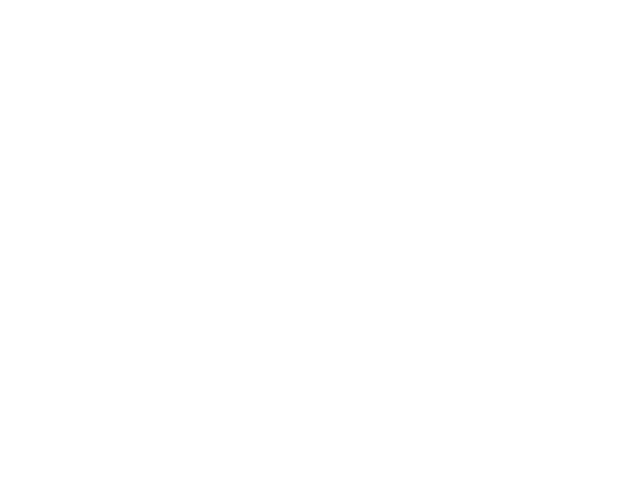

In [181]:
datas = {}
# start clear
plt.close('all')

#for i in range(nFigs):
for i in range(1):

    ######### pick things ########
    # figure
    plt.set_cmap(np.random.choice(plt.colormaps()))

    npanels, panel_style, nrows, ncols = get_nrows_and_ncols(panel_params)
    #npanels, panel_style,nrows,ncols = 1, 'horizontal', 1,1 # HACK
    plot_style = np.random.choice(plot_styles)
    if verbose: 
        print('panel style:', panel_style, 'nrows,ncols=', (nrows,ncols))
    aspect_fig = np.random.uniform(low=aspect_fig_params['min'], high=aspect_fig_params['max'])
    dpi = int(np.random.uniform(low=dpi_params['min'], high=dpi_params['max']))
    # tight layout or not
    p = np.random.uniform(low=0, high=1.0)
    if p <= tight_layout_params[True]:
        tight_layout = True
    else:
        tight_layout = False
    # font sizes
    title_fontsize = int(round(np.random.uniform(low=fontsizes['title']['min'], 
                                                 high=fontsizes['title']['max'])))
    xlabel_fontsize = int(round(np.random.uniform(low=fontsizes['xlabel']['min'], 
                                                 high=fontsizes['xlabel']['max'])))
    if not fontsizes['x/y label same']:
        ylabel_fontsize = int(round(np.random.uniform(low=fontsizes['ylabel']['min'], 
                                                      high=fontsizes['ylabel']['max'])))
    else:
        ylabel_fontsize = xlabel_fontsize # for consistancy
    xlabel_ticks_fontsize = int(round(np.random.uniform(low=fontsizes['ticks']['min'], 
                                                  high=fontsizes['ticks']['max'])))
    if not fontsizes['x/y ticks same']:
        ylabel_ticks_fontsize = int(round(np.random.uniform(low=fontsizes['ticks']['min'], 
                                                      high=fontsizes['ticks']['max'])))
    else:
        ylabel_ticks_fontsize = xlabel_ticks_fontsize # for consistancy

    # get fonts
    csfont = {'fontname':np.random.choice(font_names)}

    # plot types?
    success = False
    start_time = time.time()
    while not success:
        with plt.style.context(plot_style):
            if tight_layout:
                fig,axes = plt.subplots(nrows,ncols,figsize=(base*nrows, base*aspect_fig*ncols), 
                                        dpi=dpi,layout='tight')
            else:
                fig,axes = plt.subplots(nrows,ncols,figsize=(base*nrows, base*aspect_fig*ncols), 
                                        dpi=dpi)
                
            if npanels == 1:
                axes = [axes]
            else: # flatten, for now
                axes = axes.flatten()
                    
            ######### Generate plot data #########
            
            choices = []; probs = []
            for k,v in plot_types_params.items():
                choices.append(k)
                probs.append(v['prob'])
        
            data_for_plots = []
            plot_types = []
            data_from_plots = []
            titles = []; xlabels = []; ylabels = []; cbars = []
            end_time = time.time()
            for iplot, ax in enumerate(axes):
                start_time = time.time()
                plot_type = np.random.choice(choices, p=probs)
            
                data_for_plot = get_data(plot_types_params[plot_type],
                                plot_type=plot_type)
                end_time = time.time()
            
                ######### PLOT ############
                start_time = time.time()
                data_from_plot, ax = make_plot(plot_types_params[plot_type], data_for_plot, 
                                     ax, plot_type=plot_type)#, plot_style=plot_style)
                #import sys; sys.exit()
                end_time = time.time()

                # set ticksizes
                ax.tick_params(axis='x', which='major', labelsize=xlabel_ticks_fontsize, labelfontfamily=csfont['fontname'])
                ax.tick_params(axis='y', which='major', labelsize=ylabel_ticks_fontsize, labelfontfamily=csfont['fontname'])

                start_time = time.time()
                p = np.random.uniform(0,1)
                if p < title_params['prob']:
                    title_words = get_titles_or_labels(popular_nouns, title_params['capitalize'],
                                             title_params['equation'],
                                             nwords=np.random.randint(low=title_params['n words']['min'],
                                                                      high=title_params['n words']['max']+1))
                    title = ax.set_title(title_words, fontsize = title_fontsize, **csfont)
                else:
                    title = ''
                    
                xlabel_words = get_titles_or_labels(popular_nouns, xlabel_params['capitalize'],
                                             xlabel_params['equation'],
                                             nwords=np.random.randint(low=xlabel_params['n words']['min'],
                                                                      high=xlabel_params['n words']['max']+1))
                xlabel = ax.set_xlabel(xlabel_words, fontsize=xlabel_fontsize, **csfont)
                #ylabel = ax.set_ylabel(r"$x = 5 \times y^5$")
                ylabel_words = get_titles_or_labels(popular_nouns, ylabel_params['capitalize'],
                                             ylabel_params['equation'],
                                             nwords=np.random.randint(low=ylabel_params['n words']['min'],
                                                                      high=ylabel_params['n words']['max']+1))
                ylabel = ax.set_ylabel(ylabel_words, fontsize=ylabel_fontsize, **csfont)
                end_time = time.time()
        
                # save
                data_for_plots.append(data_for_plot)
                plot_types.append(plot_type)
                data_from_plots.append(data_from_plot)
                titles.append(title)
                xlabels.append(xlabel)
                ylabels.append(ylabel)

                if plot_type == 'scatter':
                    if 'color bar' in data_from_plot:
                        side = data_from_plot['color bar params']['side']
                        if side == 'top' or side == 'bottom':
                            orientation = 'horizontal'
                        else:
                            orientation = 'vertical'

                        cbar = fig.colorbar(data_from_plot['data'], 
                                     cax=data_from_plot['color bar'], 
                                     orientation=orientation)
                        cbars.append(cbar)

            try:
                fig.savefig(fake_figs_dir + 'Picture' + str(i+1) + '.png', dpi=dpi)
                    
                print('saved:', fake_figs_dir + 'Picture' + str(i+1) + '.png')
                success = True
            except Exception as e:
                plt.close(fig)
                print('issue with plotting, trying again')
                print(e)
    
    
    ####### end of plotting ############
    # try the whole thing again
    width, height = fig.canvas.get_width_height()
    # save data
    datas[i] = {}
    # figure datas
    datas[i]['figure'] = {'dpi':dpi, 'base':base, 'aspect ratio': aspect_fig, 
                          'nrows':nrows, 'ncols':ncols, 
                         'plot style':plot_style, 
                         'title fontsize':title_fontsize, 
                         'xlabel fontsize':xlabel_fontsize,
                         'ylabel fontsize':ylabel_fontsize}
    
    # now, get data things
    for iplot, ax in enumerate(axes):
        ###### get data from plot ######
        data_from_plot = data_from_plots[iplot]
        data_for_plot = data_for_plots[iplot]
        plot_type = plot_types[iplot]
        title = titles[iplot]
        xlabel = xlabels[iplot]
        ylabel = ylabels[iplot]
    
        data_pixels = get_data_pixel_locations(data_from_plot, plot_type, ax, width, height)
    
        # import sys; sys.exit()
    
        # bounding box of square
        bbox = ax.get_position() # Bbox(x0, y0, x1, y1)
        xpix1 = np.array([bbox.x0,bbox.x1])
        ypix1 = np.array([bbox.y0,bbox.y1])
        xpix1 *= width
        ypix1 *= height
        
        # x-tick locations
        xticks = get_ticks(ax.get_xticklabels(), ax.get_xticklines())
    
        # y-tick locations
        yticks = get_ticks(ax.get_yticklabels(), ax.get_yticklines())
        
        # for colorbars
        colorbar_ticks = []
        if 'color bar' in data_from_plots[iplot]:
            colorbar = data_from_plots[iplot]['color bar']
            if data_from_plots[iplot]['color bar params']['side'] == 'left' \
               or data_from_plots[iplot]['color bar params']['side'] == 'right':
                ticks = colorbar.get_yticklabels()
                tick_locs = colorbar.get_yticklines(minor=False)
            else:
                ticks = colorbar.get_xticklabels()
                tick_locs = colorbar.get_xticklines(minor=False)
            colorbar_ticks = get_ticks(ticks, tick_locs)

        # title
        # Get the bounding box of the title in display space
        if title != '':
            title_bbox = title.get_window_extent()
            title_words = title.get_text()
        else:
            title_bbox = -1
            title_words = ''
    
        # xlabel
        xlabel_bbox = xlabel.get_window_extent()
        xlabel_words = xlabel.get_text()
        # ylabel
        ylabel_bbox = ylabel.get_window_extent()
        ylabel_words = ylabel.get_text()
    
    
        ########## save data ##############

        # line plot 
        plot_name = 'plot' + str(iplot) 
        datas[i][plot_name] = {}
        # line plot type
        datas[i][plot_name]['type'] = plot_type # tag for just a plain line plot
        datas[i][plot_name]['data'] = data_for_plot
        datas[i][plot_name]['data pixels'] = data_pixels
        if plot_type == 'scatter' and 'color bar' in data_from_plots[iplot]:
            w = data_from_plots[iplot]['color bar'].get_window_extent()
            datas[i][plot_name]['color bar'] = {'xmin':w.x0,'ymin':w.y0,
                                                'xmax':w.x1,'ymax':w.y1, 
                                               'params':data_from_plot['color bar params']}
        xtmp = []
        for xt in xticks:
            l = {'data':xt[0], 'xmin': xt[1], 
                 'ymin': xt[2], 
                 'xmax':xt[3], 'ymax':xt[4],
                 'tx':xt[5], 'ty':xt[6]}
            xtmp.append(l)
        datas[i][plot_name]['xticks'] = xtmp.copy()
        # 
        xtmp = []
        for xt in yticks:
            l = {'data':xt[0], 'xmin': xt[1], 
                 'ymin': xt[2], 
                 'xmax':xt[3], 'ymax':xt[4], 
                'tx':xt[5], 'ty':xt[6]}
            xtmp.append(l)
        datas[i][plot_name]['yticks'] = xtmp.copy()
        if len(colorbar_ticks) > 0:
            xtmp = []
            for xt in colorbar_ticks:
                l = {'data':xt[0], 'xmin': xt[1], 
                     'ymin': xt[2], 
                     'xmax':xt[3], 'ymax':xt[4], 
                    'tx':xt[5], 'ty':xt[6]}
                xtmp.append(l)
            datas[i][plot_name]['color bar ticks'] = xtmp.copy()
            
        # axis box
        datas[i][plot_name]['square'] = {'xmin':xpix1[0], 'ymin':ypix1[0], 
                                         'xmax':xpix1[1], 'ymax':ypix1[1]}
        # title
        if title_bbox != -1:
            datas[i][plot_name]['title'] = {'xmin':title_bbox.x0, 'ymin':title_bbox.y0, 
                                            'xmax':title_bbox.x1, 'ymax':title_bbox.y1,
                                           'words':title_words}
        else:
            pass
        datas[i][plot_name]['xlabel'] = {'xmin':xlabel_bbox.x0, 'ymin':xlabel_bbox.y0, 
                                        'xmax':xlabel_bbox.x1, 'ymax':xlabel_bbox.y1,
                                       'words':xlabel_words}
        datas[i][plot_name]['ylabel'] = {'xmin':ylabel_bbox.x0, 'ymin':ylabel_bbox.y0, 
                                        'xmax':ylabel_bbox.x1, 'ymax':ylabel_bbox.y1,
                                       'words':ylabel_words}
    plt.close(fig)
print('DONE!')

In [182]:
print('DONE DONE!')

DONE DONE!


In [183]:
#inlines.tolist().index('$R\mathrm{_p}/')

In [184]:
# for i in inlines:
#     if '$R\mathrm{_p}/' in i:
#         print(i)
# #        import sys; sys.exit()

In [186]:
#plot_types_params['line']['error bars']['y']['size']['min']

In [187]:
img = np.array(Image.open(fake_figs_dir+'Picture1.png').convert('RGB'))

In [188]:
#v[p]['color bar ticks'][0]

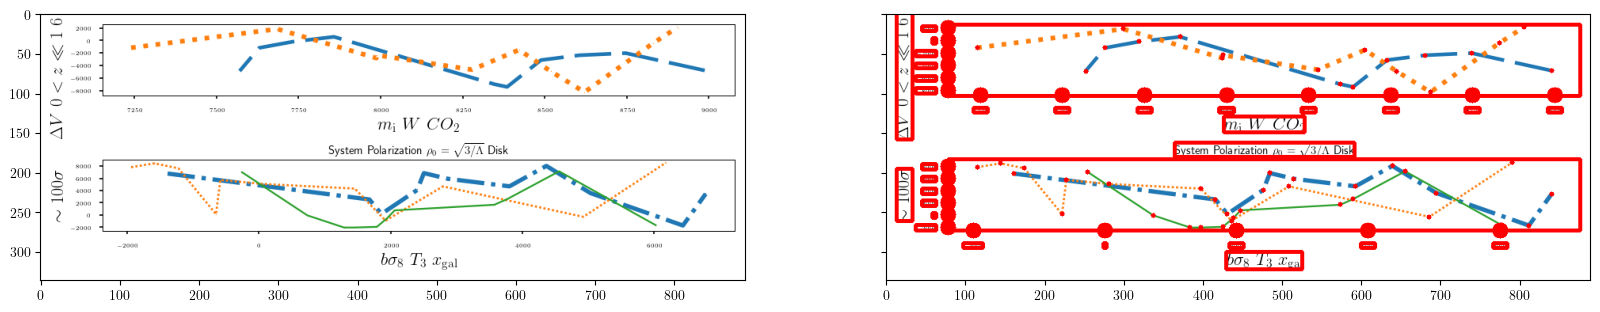

In [193]:
#%matplotlib widget
%matplotlib inline

imgplot = img.copy()

csize = 3

for k,v in datas.items(): # all figs
    for p in v:
        #print(p)
        if 'plot' in p: # not figure stuffs... just yet
            #print('PLOT:', p)
            if v[p]['type'] == 'line':
                xs = v[p]['data pixels']['xs']
                ys = v[p]['data pixels']['ys']
                for xx,yy in zip(xs,ys):
                    for x,y in zip(xx,yy):
                        cv.circle(imgplot, (int(x), int(y)), csize, (255,0,0), -1)
            elif v[p]['type'] == 'scatter':
                xs = v[p]['data pixels']['xs']
                ys = v[p]['data pixels']['ys']
                for x,y in zip(xs,ys):
                    cv.circle(imgplot, (int(x), int(y)), csize, (255,0,0), -1)
                # colormap
                if 'color bar' in v[p]:
                    xmin,ymin = int(round(v[p]['color bar']['xmin'])), int(round(img.shape[0]-v[p]['color bar']['ymin']))
                    xmax,ymax = int(round(v[p]['color bar']['xmax'])), int(round(img.shape[0]-v[p]['color bar']['ymax']))
                    cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)
                    # colormap ticks
                    if 'color bar ticks' in v[p]:
                        for d in v[p]['color bar ticks']:
                            xmin,ymin,xmax,ymax = int(d['xmin']),int(img.shape[0]-d['ymin']),int(d['xmax']),int(img.shape[0]-d['ymax'])
                            # check if we should have it or not
                            if v[p]['color bar']['params']['side'] == 'bottom' or v[p]['color bar']['params']['side'] == 'top':
                                if d['tx']>=v[p]['color bar']['xmin'] and d['tx']<=v[p]['color bar']['xmax']:
                                    cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)
                                    cv.circle(imgplot, (int(d['tx']), int(img.shape[0]-d['ty'])), 10, (255,0,0), -1)
                            else: # side
                                if d['ty']>=v[p]['color bar']['ymin'] and d['ty']<=v[p]['color bar']['ymax']:
                                    cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)
                                    cv.circle(imgplot, (int(d['tx']), int(img.shape[0]-d['ty'])), 10, (255,0,0), -1)
            else:
                print('no idea how to deal!')
                import sys; sys.exit()

            # these are things for every plot
            for d in v[p]['xticks']: # draw x-ticks
                xmin,ymin,xmax,ymax = int(d['xmin']),int(img.shape[0]-d['ymin']),int(d['xmax']),int(img.shape[0]-d['ymax'])
                if d['tx']>=v[p]['square']['xmin'] and d['tx']<=v[p]['square']['xmax']:
                    cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)
                # also ticks
                if d['tx']>=v[p]['square']['xmin'] and d['tx']<=v[p]['square']['xmax']:
                    cv.circle(imgplot, (int(d['tx']), int(img.shape[0]-d['ty'])), 10, (255,0,0), -1)
            for d in v[p]['yticks']: # draw y-ticks
                xmin,ymin,xmax,ymax = int(d['xmin']),int(img.shape[0]-d['ymin']),int(d['xmax']),int(img.shape[0]-d['ymax'])
                if d['ty']>=v[p]['square']['ymin'] and d['ty']<=v[p]['square']['ymax']:
                    cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)
                if d['ty']>=v[p]['square']['ymin'] and d['ty']<=v[p]['square']['ymax']:
                    cv.circle(imgplot, (int(d['tx']), int(img.shape[0]-d['ty'])), 10, (255,0,0), -1)
            if v[p]['type'] == 'line':
                if 'x error bars' in v[p]['data pixels']:
                    for il,l in enumerate(v[p]['data pixels']['x error bars']):
                        for ie,(xmin,ymin,xmax,ymax) in enumerate(l):
                            xmin,ymin = int(round(xmin)),int(round(img.shape[0]-ymin))
                            xmax,ymax = int(round(xmax)),int(round(img.shape[0]-ymax))
                            # only take parts within square
                            xmin = max(xmin,int(round(v[p]['square']['xmin'])))
                            xmax = min(xmax,int(round(v[p]['square']['xmax'])))
                            ymin = max(ymin,int(round(img.shape[0]-v[p]['square']['ymax'])))
                            ymax = min(ymax,int(round(img.shape[0]-v[p]['square']['ymin'])))
                            cv.line(imgplot, (xmin,ymin),(xmax,ymax), (255,0,0), 2)
                if 'y error bars' in v[p]['data pixels']:
                    for l in v[p]['data pixels']['y error bars']:
                        for xmin,ymin,xmax,ymax in l:
                            xmin,ymin = int(round(xmin)),int(round(img.shape[0]-ymin))
                            xmax,ymax = int(round(xmax)),int(round(img.shape[0]-ymax))
                            # only take parts within square
                            xmin = max(xmin,int(round(v[p]['square']['xmin'])))
                            xmax = min(xmax,int(round(v[p]['square']['xmax'])))
                            ymin = max(ymin,int(round(img.shape[0]-v[p]['square']['ymax'])))
                            ymax = min(ymax,int(round(img.shape[0]-v[p]['square']['ymin'])))
                            cv.line(imgplot, (xmin,ymin),(xmax,ymax), (255,0,0), 2)
            elif v[p]['type'] == 'scatter':
                if 'x error bars' in v[p]['data pixels']:
                    for xmin,ymin,xmax,ymax in v[p]['data pixels']['x error bars']:
                        xmin,ymin = int(round(xmin)),int(round(img.shape[0]-ymin))
                        xmax,ymax = int(round(xmax)),int(round(img.shape[0]-ymax))
                        # only take parts within square
                        xmin = max(xmin,int(round(v[p]['square']['xmin'])))
                        xmax = min(xmax,int(round(v[p]['square']['xmax'])))
                        ymin = max(ymin,int(round(img.shape[0]-v[p]['square']['ymax'])))
                        ymax = min(ymax,int(round(img.shape[0]-v[p]['square']['ymin'])))
                        cv.line(imgplot, (xmin,ymin),(xmax,ymax), (255,0,0), 2)
                if 'y error bars' in v[p]['data pixels']:
                    for xmin,ymin,xmax,ymax in v[p]['data pixels']['y error bars']:
                        #print(ymin,ymax)
                        xmin,ymin = int(round(xmin)),int(round(img.shape[0]-ymin))
                        xmax,ymax = int(round(xmax)),int(round(img.shape[0]-ymax))
                        xmin = max(xmin,int(round(v[p]['square']['xmin'])))
                        xmax = min(xmax,int(round(v[p]['square']['xmax'])))
                        ymin = max(ymin,int(round(img.shape[0]-v[p]['square']['ymax'])))
                        ymax = min(ymax,int(round(img.shape[0]-v[p]['square']['ymin'])))
                        cv.line(imgplot, (xmin,ymin),(xmax,ymax), (255,0,0), 2)
                        #print('')
            # square
            d = v[p]['square']
            xmin,ymin = int(d['xmin']),int(img.shape[0]-d['ymin'])
            xmax,ymax = int(d['xmax']),int(img.shape[0]-d['ymax'])
            cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)
            # title bounding box
            if 'title' in v[p]: # has a title?
                d = v[p]['title']
                xmin,ymin = int(d['xmin']),int(img.shape[0]-d['ymin'])
                xmax,ymax = int(d['xmax']),int(img.shape[0]-d['ymax'])
                cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)
            # xlabel bounding box
            d = v[p]['xlabel']
            xmin,ymin = int(d['xmin']),int(img.shape[0]-d['ymin'])
            xmax,ymax = int(d['xmax']),int(img.shape[0]-d['ymax'])
            cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)
            # ylabel bounding box
            d = v[p]['ylabel']
            xmin,ymin = int(d['xmin']),int(img.shape[0]-d['ymin'])
            xmax,ymax = int(d['xmax']),int(img.shape[0]-d['ymax'])
            cv.rectangle(imgplot, (xmin,ymin), (xmax,ymax), (255, 0, 0), 3)

fig2,ax2 = plt.subplots(1,2,figsize=(20,20), sharex=True, sharey=True)
ax2[0].imshow(img)
ax2[1].imshow(imgplot)
plt.show()

In [163]:
#v[p]['square']['ymin'], img.shape[0]-v[p]['square']['ymin']

In [ ]:
#ymin, ymax

In [ ]:
#v[p]['data pixels']['x error bars'][0][4]

In [ ]:
#l